# Extending The Raytracer

아직 다루지 않은 주제들이 있다.

- 카메라를 씬에서 자유롭게 배치
- 성능 최적화
- 구 외의 기초 오브젝트
- 구조적 입체 기하학(Constructive Solid Geometry)을 이용한 모델링
- 투명한 표면
- Supersampling(Anti-aliasing)

## Arbitrary Camera Positioning

지금까지는 카메라의 위치와 방향을 고정했다. 카메라의 위치는 원점 O에 방향은 z+ 방향을 바라보며 윗 뱡향은 y+ 방향이었다.

이 파트에서는 카메라의 위치와 방향을 바꿔보자. 위치를 바꾸는 법은 간단하다. 단순히 원점이었던 카메라의 위치를 다른 위치로 바꾸어주면 된다. 카메라의 위치를 바꾸었다고 해서 광선의 방향이 바뀌진 않는다. 광선은 카메라로부터 project plane을 향한다. 카메라의 위치가 변경되면 이에 맞게 project plane의 위치도 자동으로 변경되므로 상대적인 위치는 바뀌지 않는다.

카메라의 방향은 회전 행렬을 통해 변경한다.

In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [46]:
class World:
    def __init__(self,
                lights,
                spheres,
                cameras):
        self.lights = lights
        self.spheres = spheres
        self.cameras = cameras
        
        
class Light:
    def __init__(self, ltype, intensity, position=None, direction=None):
        self.ltype = ltype
        self.intensity = intensity
        self.position = np.array(position)
        self.direction = np.array(direction)
        
        
class Sphere:
    def __init__(self, center, radius, color, specular, reflective):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        
class Camera:
    def __init__(self,
                 camera_position = [0, 0, 0],
                 camera_rotation = [0, 0, 0],
                 viewport_size=1,
                 projection_plane_z=1,
                 recursion_depth=3,
                 background_color=np.array([0,0,0])):
        
        x_rotate = np.array([[1, 0, 0],
                   [0, math.cos(math.pi * camera_rotation[0] / 180), -(math.sin(math.pi * camera_rotation[0] / 180))],
                   [0, math.sin(math.pi * camera_rotation[0] / 180), math.cos(math.pi * camera_rotation[0] / 180)]])
        y_rotate = np.array([[math.cos(math.pi * camera_rotation[1] / 180),0,math.sin(math.pi * camera_rotation[1] / 180)],
                   [0, 1, 0],
                   [-(math.sin(math.pi * camera_rotation[1] / 180)), 0, math.cos(math.pi * camera_rotation[1] / 180)]])
        z_rotate = np.array([[math.cos(math.pi * camera_rotation[2] / 180), -(math.sin(math.pi * camera_rotation[2] / 180)), 0],
                   [math.sin(math.pi * camera_rotation[2] / 180), math.cos(math.pi * camera_rotation[2] / 180), 0],
                   [0, 0, 1]])
        
        self.position = np.array(camera_position)
        self.rotation = np.dot(np.dot(x_rotate, y_rotate), z_rotate)
        self.viewport_size = viewport_size # view port size in world unit
        self.projection_plane_z = projection_plane_z # view port's distance from camera in world unit
        
        self.t_min = 1
        self.t_max = math.inf
        
        self.background_color = background_color
        
        self.recursion_depth = recursion_depth

    
    def traceray(self,
                 origin, 
                 direction,
                 spheres = None, 
                 lights = None,
                 recursion_depth=3):
        origin = origin
        t_min = self.t_min
        t_max = self.t_max
        spheres = spheres
        closest_sphere, closest_t = self.intersect_closest_point(origin,
                                                        direction,
                                                        t_min,
                                                        t_max,
                                                        spheres)

        if closest_sphere == None:
            return self.background_color

        point = np.add(origin, np.multiply(closest_t, direction))
        normal = np.subtract(point, closest_sphere.center)
        normal = np.multiply(1.0 / np.linalg.norm(normal), normal)
        view = np.multiply(-1, direction)
        
        local_color = self.compute_light(point, normal, view, closest_sphere.specular, lights, spheres) * closest_sphere.color
        
        # if recurrsion limit  or object is not reflective, end
        r = closest_sphere.reflective
        if recursion_depth <= 0 or r <= 0:
            return local_color
        
        
        # Compute reflected color
        R = self.reflect_ray(view, normal)
        
        reflected_color = self.traceray(point, R, spheres, lights, recursion_depth - 1)
        
        return local_color*(1-r) + reflected_color*r
    
        # smwoo
    def intersect_closest_point(self, origin, direction, t_min, t_max, spheres):
        closet_t = math.inf
        closet_sphere = None
        
        for sphere in spheres:
            
            t = self.intersect_ray_sphere(origin, direction, sphere)
            
            if (t_min < t[0] < t_max) & (t[0] < closet_t):
                closet_t = t[0]
                closet_sphere = sphere
                
            if (t_min < t[1] < t_max) & (t[1] < closet_t):
                closet_t = t[1]
                closet_sphere = sphere
                
        return closet_sphere, closet_t
    
    
    def intersect_ray_sphere(self, origin, direction, sphere):
        origin = origin
        
        oc = np.subtract(origin, sphere.center)

        k1 = np.dot(direction, direction)
        k2 = 2*np.dot(oc, direction)
        k3 = np.dot(oc, oc) - sphere.radius*sphere.radius

        discriminant = k2*k2 - 4*k1*k3
        if (discriminant < 0):
            return [math.inf, math.inf]

        t1 = (-k2 + math.sqrt(discriminant)) / (2*k1)
        t2 = (-k2 - math.sqrt(discriminant)) / (2*k1)
        return [t1, t2]
    
    def compute_light(self, point, normal, view, specular, lights, spheres):
        intensity = 0
        length_n = np.linalg.norm(normal)
        length_v = np.linalg.norm(view)
        for i, light in enumerate(lights):
            if light.ltype == 0:
                intensity += light.intensity
            else :
                vec_l = []
                if light.ltype == 1:
                    vec_l = np.subtract(light.position, point)
                    t_max = 1
                else :  #DIRECTIONAL
                    vec_l = light.direction
                    t_max = math.inf
        
            #Shadow check
                shadow_sphere, shadow_t = self.intersect_closest_point(point, vec_l, 0.001, t_max, spheres)
                if shadow_sphere != None:
                    continue
                
          # Diffuse reflection.
                n_dot_l = np.dot(normal, vec_l)
                if( n_dot_l > 0) :
                    intensity += light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l))


          # Specular reflection.
                if (specular != -1 ):
                    vec_r = 2 * normal * np.dot(normal, vec_l) - vec_l
                    # vec_r = np.subtract(np.multiply(2.0*np.dot(normal, vec_l), normal), vec_l)
                    r_dot_v = np.dot(vec_r, view)
                    if (r_dot_v > 0):
                        intensity += light.intensity * math.pow(r_dot_v / (np.linalg.norm(vec_r) * length_v), specular)
        return np.array(intensity)
    
    def reflect_ray(self,R,N):
        return 2 * N * np.dot(N, R) - R

In [47]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8)
        
    def putpixel(self, x, y, color):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B))
        
        
class Renderer:
    '''
    Canvas
    World
    '''
    def __init__(self,
                canvas,
                world):
        self.canvas = canvas 
        self.world = world
    
    def render(self, camera_idx=0):
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        
        
        
        x_s = -canvas_width/2
        y_s = -canvas_height/2
        
        for i in range(canvas_width):
            for j in range(canvas_height):
                curr_x = x_s + i
                curr_y = y_s + j
                direction = self.canvas2viewport([curr_x, curr_y], camera_idx)
                direction = np.dot(self.world.cameras[camera_idx].rotation, direction)
                color = self.traceray(camera_idx, direction)
                #color = traceray(camera_position, direction, 1, math.inf)
                self.canvas.putpixel(curr_x, curr_y,color)
        
        plt.imshow(self.canvas.img)
        return 
    
    def canvas2viewport(self, point2d, camera_idx):
        camera = self.world.cameras[camera_idx]
        
        viewport_size = camera.viewport_size
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        projection_plane_z = camera.projection_plane_z
        
        return [point2d[0] * viewport_size / canvas_width, point2d[1] * viewport_size / canvas_height, projection_plane_z]
    
    def traceray(self, camera_idx, direction):
        camera = self.world.cameras[camera_idx]
        
        color = camera.traceray(camera.position,
                                direction,  
                                spheres=self.world.spheres, 
                                lights = self.world.lights,
                                recursion_depth=camera.recursion_depth)
        
        # color = traceray(camera_position, direction, 1, math.inf)
        return color

In [100]:
AMBIENT = 0
POINT = 1
DIRECTIONAL = 2

light1 = Light(AMBIENT, 0.2, None)
light2 = Light(POINT, 0.6, position=[2,1,0])
light3 = Light(DIRECTIONAL, 0.2, direction=[1,4,4])
lights = [light1, light2, light3]


sphere1 = Sphere([0, -1, 3], 1, [255, 0, 0], 500, 0.2)
sphere2 = Sphere([2, 0, 4], 1, [0, 255, 0], 500, 0.3)
sphere3 = Sphere([-2, 0, 4], 1, [0, 0, 255], 10, 0.4)
sphere4 = Sphere([0, -5001, 0], 5000, [255, 255, 0], 1000, 0.5)
spheres = [sphere1, sphere2, sphere3, sphere4]

camera1 = Camera(camera_position=[3,0,1], camera_rotation=[0,-45,0], recursion_depth=0) # no reflection
camera2 = Camera(camera_position=[0,3,0], camera_rotation=[45,0,0], recursion_depth=3)# reflection
camera3 = Camera(camera_position=[0,10,3], camera_rotation=[90,0,0], recursion_depth=0, background_color=[255,255,255])
cameras = [camera1, camera2, camera3]

world = World(lights=lights,
             spheres=spheres,
             cameras=cameras)

canvas = Canvas()

renderer = Renderer(canvas, world)

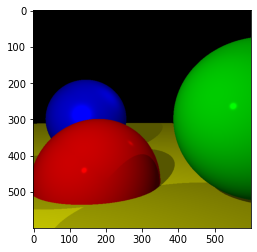

In [67]:
renderer.render()

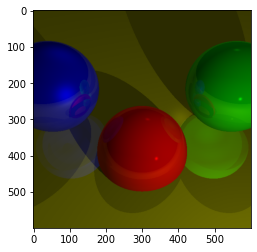

In [69]:
renderer.render(camera_idx = 1)

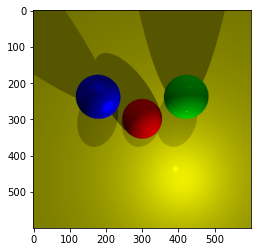

In [101]:
renderer.render(camera_idx = 2)

## Performance Optimizations

이전까지는 raytracer를 가장 명확하게 설명하는 것에 중점을 두었다. 이번 파트에서는 성능을 좀더 끌어올리는 방법을 알아볼 것이다.